In [0]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import pickle
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn import linear_model, tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import PolynomialFeatures

In [0]:
return_table_name=dbutils.notebook.run("notebook_dataprep",60)
print(return_table_name)
global_temp_db = spark.conf.get("spark.sql.globalTempDatabase")
df = (spark.table(global_temp_db + "." + return_table_name)).toPandas()

titanic_2


#### Modeling

In [0]:
columns_selected = ['survived', 'ticket_class', 'sex', 'age_group_encoding', 'num_parch', 'fare', 'emb_port']
df_model = df[columns_selected]
df_model.loc[df_model['sex']=='male', 'sex']=0
df_model.loc[df_model['sex']=='female', 'sex']=1
df_model.loc[df_model['emb_port']=='C', 'emb_port']=0
df_model.loc[df_model['emb_port']=='Q', 'emb_port']=1
df_model.loc[df_model['emb_port']=='S', 'emb_port']=2
# df_model.loc[:, 'fare_group'] = df_model['fare_group'].astype('int')

x_train, x_test, y_train, y_test = train_test_split(df_model.loc[:, df_model.columns != 'survived'], df_model['survived'], test_size=0.2, random_state=42)

In [0]:
lr = linear_model.LogisticRegression()
lr.fit(x_train, y_train)
print('train accuracy: {}, test accuracy: {}'.format(accuracy_score(lr.predict(x_train), y_train), accuracy_score(lr.predict(x_test), y_test)))

train accuracy: 0.8059071729957806, test accuracy: 0.7808988764044944


In [0]:
ridge = linear_model.RidgeCV(np.logspace(-6, 6, 13))
ridge.fit(x_train, y_train)
print('train accuracy: {}, test accuracy: {}'.format(accuracy_score((ridge.predict(x_train) >= 0.5).astype('int'), y_train), \
                                                     accuracy_score((ridge.predict(x_test) >= 0.5).astype('int'), y_test)))

train accuracy: 0.7876230661040787, test accuracy: 0.7921348314606742


In [0]:
poly = PolynomialFeatures(degree = 2, interaction_only=False, include_bias=False)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)
lr_poly = linear_model.LogisticRegression()
lr_poly.fit(x_train_poly, y_train)
print('train accuracy: {}, test accuracy: {}'.format(accuracy_score(lr_poly.predict(x_train_poly), y_train), accuracy_score(lr_poly.predict(x_test_poly), y_test)))

train accuracy: 0.7524613220815752, test accuracy: 0.7808988764044944


/databricks/python/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [0]:
dtree = DecisionTreeClassifier()
dtree.fit(x_train, y_train)
print('train accuracy: {}, test accuracy: {}'.format(accuracy_score(dtree.predict(x_train), y_train), accuracy_score(dtree.predict(x_test), y_test)))

train accuracy: 0.9465541490857946, test accuracy: 0.7808988764044944


In [0]:
grid = {'criterion':['gini','entropy'],'max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}
kfold = RepeatedKFold(n_splits=10, random_state=42)
dtree_kfold = DecisionTreeClassifier()
grid_search = GridSearchCV(dtree_kfold, grid, cv=kfold)
dtree_best = grid_search.fit(x_train, y_train)

print('train accuracy: {}, test accuracy: {}'.format(accuracy_score(dtree_best.predict(x_train), y_train), accuracy_score(dtree_best.predict(x_test), y_test)))

train accuracy: 0.8973277074542897, test accuracy: 0.7865168539325843


In [0]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(x_train, y_train)
print('train accuracy: {}, test accuracy: {}'.format(accuracy_score(rf.predict(x_train), y_train), accuracy_score(rf.predict(x_test), y_test)))

train accuracy: 0.9465541490857946, test accuracy: 0.7921348314606742


In [0]:
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
# mfeatures = [2, 3, 4, 5, 6]
grid = dict(learning_rate=learning_rate) #, max_features=mfeatures)
kfold = RepeatedKFold(n_splits=10, random_state=42)
gbc = GradientBoostingClassifier(n_estimators=200,
                                 # learning_rate=0.05,
                                 max_features=6,
                                 random_state=42)

grid_search = GridSearchCV(gbc, grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
gbc_best = grid_search.fit(x_train, y_train)

# gbc.fit(x_train, y_train)
print('train accuracy: {}, test accuracy: {}'.format(accuracy_score(gbc_best.predict(x_train), y_train), accuracy_score(gbc_best.predict(x_test), y_test)))

train accuracy: 0.9240506329113924, test accuracy: 0.8314606741573034


In [0]:
with open('gbc.pkl', 'wb') as file:
    pickle.dump(gbc_best, file)

with open('dtree.pkl', 'wb') as file:
    pickle.dump(dtree, file)    

In [0]:
x_train_out =  spark.createDataFrame(x_train)
x_train_out.createOrReplaceGlobalTempView('x_train_out')

x_test_out =  spark.createDataFrame(x_test)
x_test_out.createOrReplaceGlobalTempView('x_test_out')

y_train_out =  spark.createDataFrame(pd.DataFrame(y_train))
y_train_out.createOrReplaceGlobalTempView('y_train_out')

y_test_out =  spark.createDataFrame(pd.DataFrame(y_test))
y_test_out.createOrReplaceGlobalTempView('y_test_out')

dbutils.notebook.exit("y_test_out")

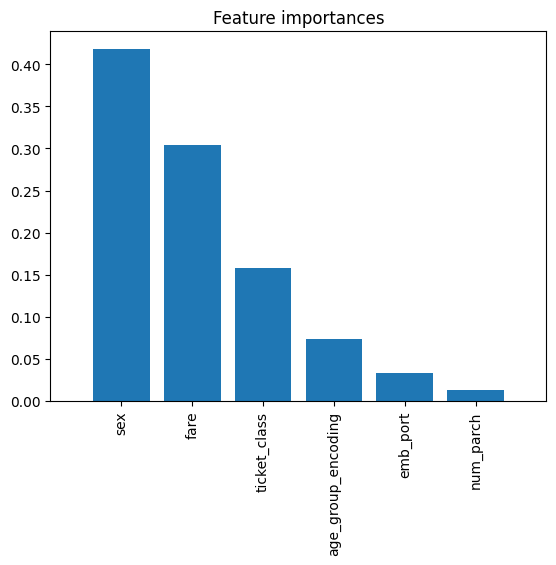

In [0]:
importances = gbc_best.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices], align="center")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices], rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.show()

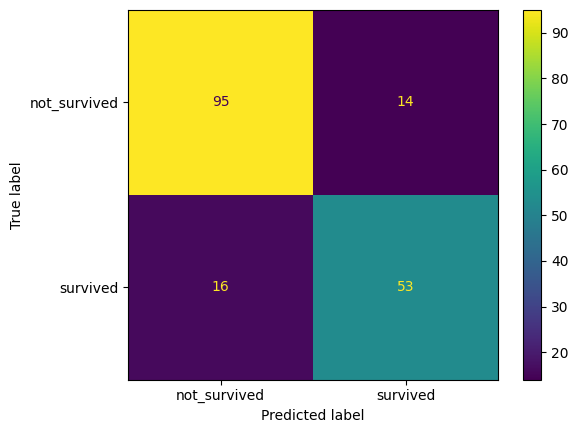

In [0]:
cm = confusion_matrix(y_true=y_test, y_pred=gbc_best.predict(x_test))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['not_survived', 'survived']) 
cm_display.plot()
# sns.heatmap(cm, annot=True, cmap='Blues')

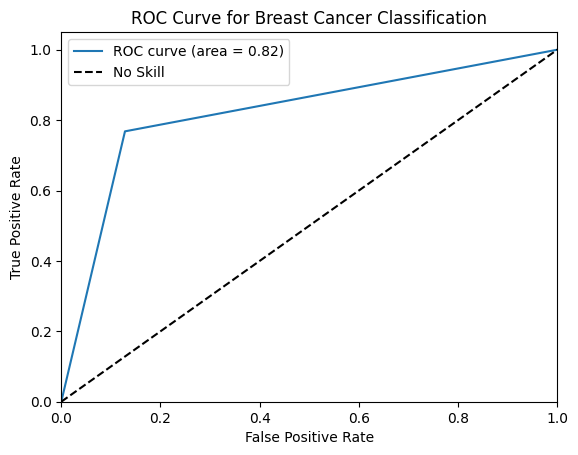

In [0]:
fpr, tpr, thresholds = roc_curve(y_test, gbc_best.predict(x_test))
roc_auc = auc(fpr, tpr)
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Breast Cancer Classification')
plt.legend()
plt.show()

In [0]:
with open('model.pkl', 'rb') as file:
    m = pickle.load(file)
m

GridSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=10, random_state=42),
             estimator=GradientBoostingClassifier(max_features=6,
                                                  n_estimators=200,
                                                  random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]},
             scoring='neg_log_loss')

In [0]:
from azure.storage.blob import BlobServiceClient

blob_service_client = BlobServiceClient.from_connection_string("DefaultEndpointsProtocol=https;AccountName=chakssa;AccountKey=igtnp8QaR6wyg8QqSrly+MZlYoTtXn7mQxYUbkYUyJKTTtuFtbe6A8GT+IrB/jurKRzR9KtIPwB5+AStruAw/A==;EndpointSuffix=core.windows.net")

blob_name = "gbc.pkl"
blob_client = blob_service_client.get_blob_client(container='wendy', blob=blob_name)
with open('gbc.pkl', "rb") as data:
    blob_client.upload_blob(data, overwrite=True)

blob_name = "dtree.pkl"
blob_client = blob_service_client.get_blob_client(container='wendy', blob=blob_name)
with open('dtree.pkl', "rb") as data:
    blob_client.upload_blob(data, overwrite=True)